### Implementation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/output.csv", encoding='latin-1')

In [ ]:
#Removing the null values
df = df.dropna()
print(df.isna().sum())

PATH     0
VALUE    0
LABEL    0
dtype: int64


In [ ]:
value_counts = df['LABEL'].value_counts()
print(value_counts)

DESCRIPTION    4046
CVE            4000
SEVERITY       3932
IRRELEVANT     1651
Name: LABEL, dtype: int64


In [ ]:
df['PATH'] = df['PATH'].str.replace('.', ' ')

target_label = "CVE"
mask = df['LABEL'] == target_label
df.loc[mask, 'VALUE'] = df.loc[mask, 'VALUE'].apply(lambda x: x.replace("-", " "))


<ipython-input-68-d9cf6899bb9c>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['PATH'] = df['PATH'].str.replace('.', ' ')


In [ ]:
df['text'] = df["PATH"].astype(str) + " ------- " +df["VALUE"].astype(str)
df['label'] = df["LABEL"]

In [ ]:
df.head()

,PATH,VALUE,LABEL,text,label
0,name,2.6.1,IRRELEVANT,name ------- 2.6.1,IRRELEVANT
1,version,5.2.15-2+b2,IRRELEVANT,version ------- 5.2.15-2+b2,IRRELEVANT
2,builds[] build_id,1:2.38.1-5+b1,IRRELEVANT,builds[] build_id ------- 1:2.38.1-5+b1,IRRELEVANT
3,components[] id,9.1-1,IRRELEVANT,components[] id ------- 9.1-1,IRRELEVANT
4,artifacts[] issues[] PackageName,9.1-1,IRRELEVANT,artifacts[] issues[] PackageName ------- 9.1-1,IRRELEVANT


In [ ]:
df = df[['text','label']]

In [ ]:
df = df[df['label'] != "IRRELEVANT"]

In [ ]:
value_counts = df['label'].value_counts()
print(value_counts)

DESCRIPTION    4046
CVE            4000
SEVERITY       3932
Name: label, dtype: int64


# KMEANS

In [ ]:
import gensim
from sklearn.cluster import KMeans

In [ ]:
tokenized_texts = [text.split() for text in df["text"].tolist()]

In [ ]:
w2vModel = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, sg=0)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0

    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)

    return feature_vector

In [ ]:
vocab = w2vModel.wv.index_to_key


In [ ]:
vectorized_texts = [average_word_vectors(text, w2vModel, vocab, 300) for text in tokenized_texts]

In [ ]:
print(len(vectorized_texts))

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(vectorized_texts)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [ ]:
wcss = []

k_values = range(1, 20)

# Calculate WCSS for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vectorized_texts)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(8, 4))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('WCSS vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()


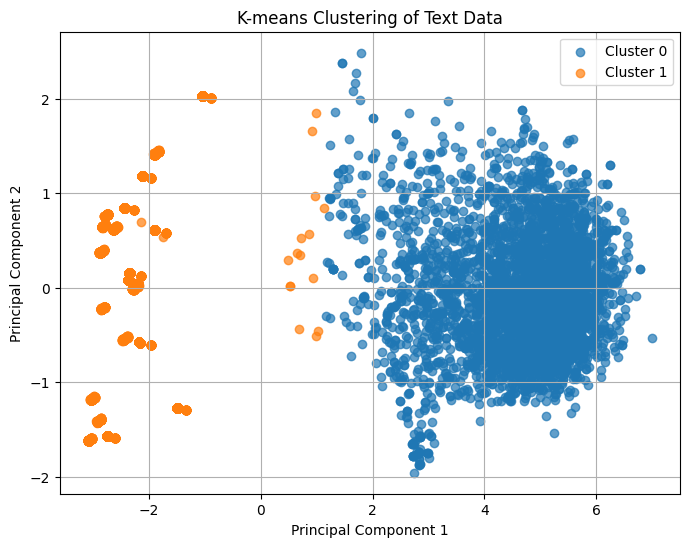

In [ ]:
from sklearn.decomposition import PCA

# Assuming you have already performed K-means clustering and have cluster labels
# Replace 'cluster_labels' with your actual cluster labels
cluster_labels = kmeans.labels_  # Replace with your cluster labels

# Reduce the dimensionality of your vectorized texts for plotting (e.g., using PCA)
pca = PCA(n_components=2)  # You can adjust the number of components as needed
vectorized_texts_2d = pca.fit_transform(vectorized_texts)

# Plot the clusters
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(8, 6))

for label in unique_labels:
    plt.scatter(
        vectorized_texts_2d[cluster_labels == label, 0],
        vectorized_texts_2d[cluster_labels == label, 1],
        label=f'Cluster {label}',
        alpha=0.7,
    )

plt.title('K-means Clustering of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
distances = kmeans.transform(vectorized_texts)

In [ ]:
print(distances)

[[7.41684578 1.41003559]
 [7.6440475  1.85865291]
 [7.18090666 1.13574127]
 ...
 [6.85776016 1.86303133]
 [6.70134017 1.1659893 ]
 [6.61764935 1.011634  ]]


# MODEL - LSTM

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_values = tfidf_vectorizer.fit_transform(df['text'])

In [ ]:
# from sklearn.ensemble import IsolationForest

# iso_forest = IsolationForest()
# iso_forest.fit(tfidf_values)

In [ ]:
# tfidf_value = tfidf_vectorizer.transform(["12345566 12345567"])
# is_outlier = iso_forest.predict(tfidf_value)[0] == -1
# print(is_outlier)

In [ ]:
df = df.sort_values(by='label', ascending=True, ignore_index= True)
columns = df['label'].unique()

In [ ]:
print(df)

                                                    text     label
0      artifacts[] issues[] cves[] ID ------- CVE 199...       CVE
1      advisories data cves[]artifacts[] issues[] cve...       CVE
2      artifacts[] issues[] cves[] idartifacts[] issu...       CVE
3      advisories data cves[]artifacts[] issues[] cve...       CVE
4          data[] Vulnerability id ------- CVE 1999 0896       CVE
...                                                  ...       ...
11973                data[] Security Risk ------- MEDIUM  SEVERITY
11974                        cves[] Severity ------- LOW  SEVERITY
11975  Results[] Vulnerabilities[] Severity ------- M...  SEVERITY
11976                       data[] severity ------- HIGH  SEVERITY
11977                     cves[] Severity ------- MEDIUM  SEVERITY

[11978 rows x 2 columns]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
int_encoded = label_encoder.fit_transform(df['label'].values)

In [ ]:
print(int_encoded)

[0 0 0 ... 2 2 2]


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the integer encoded labels
one_hot_encoded = to_categorical(int_encoded, num_classes=3)


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(11978, 2)

In [ ]:
print(df.loc[8982])

text     cves[] Severity ------- HIGH
label                        SEVERITY
Name: 8982, dtype: object


In [ ]:
one_hot_df = pd.DataFrame(one_hot_encoded, columns=df['label'].unique())

In [ ]:
print(one_hot_df)

       CVE  DESCRIPTION  SEVERITY
0      1.0          0.0       0.0
1      1.0          0.0       0.0
2      1.0          0.0       0.0
3      1.0          0.0       0.0
4      1.0          0.0       0.0
...    ...          ...       ...
11973  0.0          0.0       1.0
11974  0.0          0.0       1.0
11975  0.0          0.0       1.0
11976  0.0          0.0       1.0
11977  0.0          0.0       1.0

[11978 rows x 3 columns]


In [ ]:
one_hot_df.shape

(11978, 3)

In [ ]:
print(one_hot_df.loc[8982])

CVE            0.0
DESCRIPTION    0.0
SEVERITY       1.0
Name: 8982, dtype: float32


In [ ]:
df.head()

,text,label
0,artifacts[] issues[] cves[] ID ------- CVE 199...,CVE
1,advisories data cves[]artifacts[] issues[] cve...,CVE
2,artifacts[] issues[] cves[] idartifacts[] issu...,CVE
3,advisories data cves[]artifacts[] issues[] cve...,CVE
4,data[] Vulnerability id ------- CVE 1999 0896,CVE


In [ ]:
# Concatenate this new DataFrame with the original df
df = pd.concat([df.drop('label', axis=1), one_hot_df], axis=1)

In [ ]:
df.head()

,text,CVE,DESCRIPTION,SEVERITY
0,artifacts[] issues[] cves[] ID ------- CVE 199...,1.0,0.0,0.0
1,advisories data cves[]artifacts[] issues[] cve...,1.0,0.0,0.0
2,artifacts[] issues[] cves[] idartifacts[] issu...,1.0,0.0,0.0
3,advisories data cves[]artifacts[] issues[] cve...,1.0,0.0,0.0
4,data[] Vulnerability id ------- CVE 1999 0896,1.0,0.0,0.0


In [ ]:
print(df.loc[8982])

text           cves[] Severity ------- HIGH
CVE                                     0.0
DESCRIPTION                             0.0
SEVERITY                                1.0
Name: 8982, dtype: object


In [ ]:
df = df.dropna()

In [ ]:
#splitting data into train, validation and test sets. 80 10 10 split.
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
train.shape

(9582, 4)

In [ ]:
# #Convert the pandas dataframe into tensorflow dataset
# def df_to_dataset(dataframe, batch_size=1024):
#   df = dataframe.copy()
#   labels = df.pop('label')
#   df = df["text"]
#   ds = tf.data.Dataset.from_tensor_slices((df, labels))
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(tf.data.AUTOTUNE)
#   return ds
def df_to_dataset(dataframe, batch_size=1024):
    df = dataframe.copy()
    label_columns = columns # Adjust based on your label column names
    labels = df[label_columns]
    df = df.drop(label_columns, axis=1)  # Drop label columns
    df = df["text"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
print(train.head())

                                                    text  CVE  DESCRIPTION  \
478    data[] component_versions more_details cves[] ...  1.0          0.0   
10286       artifacts[] issues[] issue_type ------- HIGH  0.0          0.0   
9773                         cves[] severity ------- LOW  0.0          0.0   
3965   advisories data cves[]artifacts[] issues[] cve...  1.0          0.0   
11613              advisories data severity ------- HIGH  0.0          0.0   

       SEVERITY  
478         0.0  
10286       1.0  
9773        1.0  
3965        0.0  
11613       1.0  


In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
ds_labels = [labels for _, labels in train_data.unbatch()]

In [ ]:
print(ds_labels)

[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>, <tf.Tensor: sha

In [ ]:
#creating a text vectorization layer
encoder = tf.keras.layers.TextVectorization(max_tokens=4001)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
#Ensuring the vocabulary produced by the encoder is correct
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'data', 'cves', 'cve', 'to', 'the', 'a', 'issues',
       '1999', 'severity', 'in', 'allows', 'artifacts', 'vulnerabilities',
       'high', 'results', 'description', 'advisories', 'and'],
      dtype='<U25')

In [ ]:
#creating a model with embedding layer, LSTM layer and dense layer
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#creating a callback to stop training if validation accuracy does not improve for 2 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=1,
    restore_best_weights=True,
)

In [ ]:
#training the model
history = model.fit(train_data, epochs=30, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/30
10/10 [==============================] - 8s 320ms/step - loss: 1.0841 - accuracy: 0.5639 - val_loss: 1.0586 - val_accuracy: 0.7012
Epoch 2/30
10/10 [==============================] - 0s 25ms/step - loss: 1.0289 - accuracy: 0.7470 - val_loss: 0.9657 - val_accuracy: 0.8781
Epoch 3/30
10/10 [==============================] - 0s 25ms/step - loss: 0.8828 - accuracy: 0.8962 - val_loss: 0.7294 - val_accuracy: 1.0000
Epoch 4/30
10/10 [==============================] - 0s 25ms/step - loss: 0.6591 - accuracy: 0.9794 - val_loss: 0.5433 - val_accuracy: 1.0000
Epoch 5/30
10/10 [==============================] - 0s 25ms/step - loss: 0.4852 - accuracy: 0.9985 - val_loss: 0.3783 - val_accuracy: 0.9992
Epoch 6/30
10/10 [==============================] - 0s 26ms/step - loss: 0.3351 - accuracy: 0.9981 - val_loss: 0.2502 - val_accuracy: 0.9975
Epoch 7/30
10/10 [==============================] - 0s 25ms/step - loss: 0.2267 - accuracy: 0.9975 - val_loss: 0.1616 - val_accuracy: 0.9967
Epoch 8/30
1

# Part D - Testing


keras model.evaluate returns loss and accuracy metrics for the model (https://keras.io/api/models/model_training_apis/#evaluate-method)

In [ ]:
model.evaluate(test_data)

2/2 [==============================] - 0s 15ms/step - loss: 0.0076 - accuracy: 0.9992


[0.007648656610399485, 0.9991652965545654]

The history of the model during training is used to plot a graph of the validation accuracy and the training accuracy to check for overfitting issues

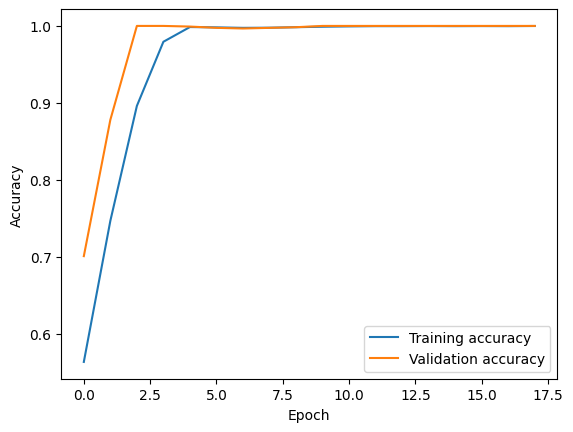

In [ ]:
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

A confusion matrix is used to visualize how well the model performs for both classes. Here the test values are used to get predictions and are validated against the true labels.

2/2 [==============================] - 2s 13ms/step
[2 0 1 ... 2 0 1]


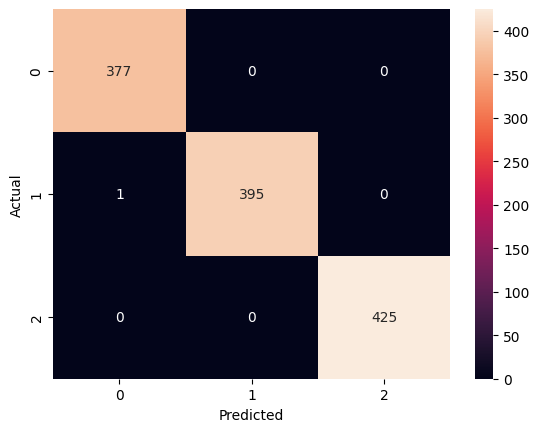

In [ ]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import seaborn as sns

# predicted_labels = np.argmax(model_outputs, axis=1)
# Build and show confusion matrix
y_test = np.concatenate([y for x, y in test_data], axis=0)
true_labels = np.argmax(y_test, axis=1)
y_pred = model.predict(test_data)
predicted_labels = np.argmax(y_pred, axis=1)

print(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



The accuracy, precision and recall score are printed out here.
- Accuracy measures the overall correctness of the model by calculating the ratio of correctly predicted instances to the total instances
- Precision assesses the accuracy of the positive predictions made by the model
- Recall measures the ability of the model to capture all the positive instances.